<a href="https://www.kaggle.com/code/nikhil1e9/goodreads-books-analysis?scriptVersionId=191415594" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from datetime import datetime
from collections import defaultdict

%matplotlib inline
sns.set(style="darkgrid", palette="Set2")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load data

In [2]:
# Function to load the data
def load_data(path):
    df = pd.read_csv(path)
    df = df.iloc[:, :-1]
    return df

for dirname, _, filenames in os.walk('/kaggle/input'):
    filepath = []
    for filename in filenames:
        path = os.path.join(dirname, filename)
        filepath.append(path)
        
books_df = load_data(filepath[0])

In [3]:
# Taking a look at the data
books_df.sample(5)

,Title,Author,Score,Ratings,Shelvings,Published,Description
26540,Closely Watched Trains,Bohumil Hrabal,3.75,10928,12291,1965,Bohumil Hrabal's post-war classic about a youn...
2914,Henry Miller on Writing,Henry Miller,4.23,1216,4847,1964,Some of the most rewarding pages in Henry Mill...
22961,Percy Jackson and the Olympians (Percy Jackson...,Rick Riordan,4.54,45004,60425,2008,3 Book Paperback Boxed Set with new coversHuma...
23209,"Gemina (The Illuminae Files, #2)",Amie Kaufman,4.44,76499,125987,2016,Moving to a space station at the edge of the g...
9888,The Push,Ashley Audrain,4.06,339742,678727,2021,An alternative cover edition for this ISBN can...


In [4]:
# General inforamtion about the data
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27621 entries, 0 to 27620
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Title        27621 non-null  object 
 1   Author       27621 non-null  object 
 2   Score        27621 non-null  float64
 3   Ratings      27621 non-null  int64  
 4   Shelvings    27621 non-null  int64  
 5   Published    27621 non-null  int64  
 6   Description  27549 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 1.5+ MB


In [5]:
# Percentage of null values across columns
books_df.isnull().mean() * 100

Title          0.000000
Author         0.000000
Score          0.000000
Ratings        0.000000
Shelvings      0.000000
Published      0.000000
Description    0.260671
dtype: float64

Some of the descriptions are null values. These are only a small fraction of the whole dataset (0.26%) so can be safely removed without significant information loss.

In [6]:
books_df.describe().T.style.background_gradient(cmap='RdYlGn_r')

,count,mean,std,min,25%,50%,75%,max
Score,27621.000000,3.968637,0.284129,2.140000,3.800000,3.990000,4.160000,5.000000
Ratings,27621.000000,44113.639369,200211.301907,1.000000,787.000000,4649.000000,26965.000000,9596885.000000
Shelvings,27621.000000,75021.492162,280599.247845,51.000000,1913.000000,11803.000000,49746.000000,10863204.000000
Published,27621.000000,1967.833496,38.745116,1900.000000,1934.000000,1969.000000,2003.000000,2024.000000


- The median book score is 3.99/5 which means that the dataset contains many good quality books.
- Book Ratings vary from 1 to all the way up to 9.6 million
- Similarly, Shelvings also have maximum value of 10.8 million
- The dataset contains books published in the year 1900 to all the way upto the current year.

# Data Cleaning

Some book titles contain the series names to which they belong. Let's separate them out and create a new feature with the series names.

In [7]:
# Separating the series titles from book titles
books_df['Series'] = books_df['Title'].apply(lambda x: x.split('(')[1][:-3].strip().split(',')[0] if len(x.split('('))>1 else "Standalone")
books_df['Title'] = books_df['Title'].apply(lambda x: x.split('(')[0])
books_df[books_df['Series'] != "Standalone"].sample(5)

,Title,Author,Score,Ratings,Shelvings,Published,Description,Series
4217,Finger Lickin' Fifteen,Janet Evanovich,4.02,90626,135361,2009,Unbuckle your belt and pull up a chair. It's t...,Stephanie Plum
3475,UnWholly,Neal Shusterman,4.24,60066,104283,2012,It’s finally here. The long-awaited sequel to ...,Unwind
17401,A Cruel Arrangement,Tijan,4.06,7828,22718,2023,From New York Times bestselling author Tijan c...,Kings of New York
22991,The Dating Plan,Sara Desai,3.63,43464,152250,2021,Daisy Patel is a software engineer who underst...,Marriage Game
5016,Mr. Masters,T.L. Swan,4.20,62247,128774,2018,"He is powerful, older and my boss, a lethal co...",Mr. Series


In [8]:
series = books_df[books_df['Series'] != "Standalone"].shape[0]
print("Total number of books part of a series:", series)

Total number of books part of a series: 8282


In [9]:
books_df[books_df['Series'] == "Standalone"].sample(5)

,Title,Author,Score,Ratings,Shelvings,Published,Description,Series
17412,Androcles and the Lion,George Bernard Shaw,3.64,788,1529,1912,Androcles and the Lion is a 1912 play written ...,Standalone
24179,Songs of Distant Earth,Arthur C. Clarke,3.91,15957,22340,1986,"Just a few islands in a planetwide ocean, Thal...",Standalone
15022,Anatomy of a Murder,Robert Traver,4.04,3164,8535,1958,Librarian's note: An alternate cover edition c...,Standalone
14657,The Feather Pillow and the Permanent Stiletto,Horacio Quiroga,3.74,47,196,1917,"A combined volume of the two short stories, Th...",Standalone
10563,The Sea Around Us,Rachel Carson,4.18,4302,17387,1951,The Sea Around Us is one of the most influenti...,Standalone


In [10]:
standalone = books_df[books_df['Series'] == "Standalone"].shape[0]
print("Total number of standalone books:", standalone)

Total number of standalone books: 19339


# EDA

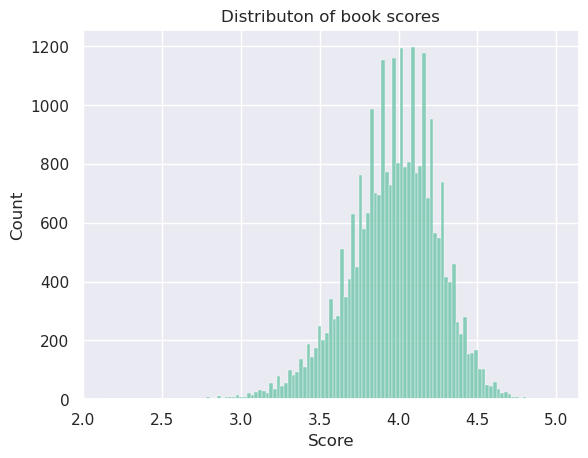

In [11]:
sns.histplot(data=books_df, x='Score')
plt.title("Distributon of book scores")
plt.show()

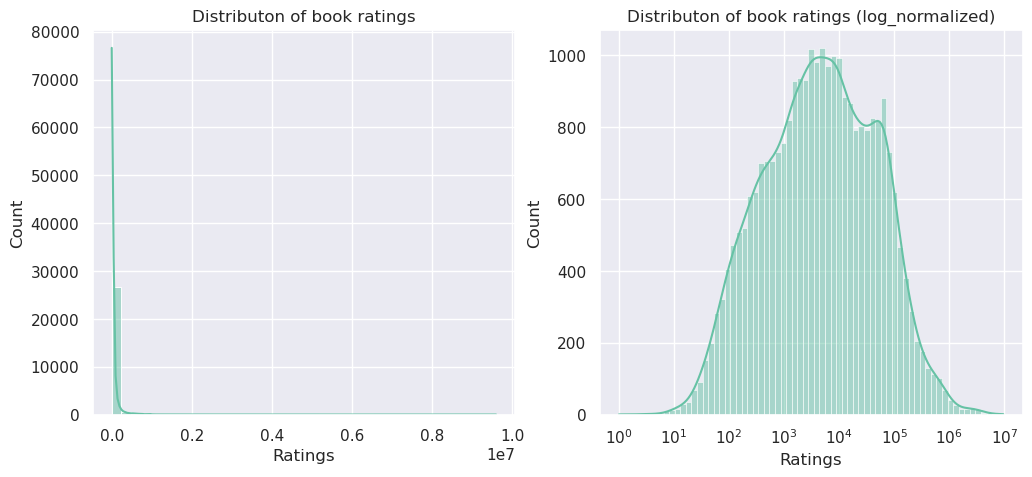

In [12]:
fig, axes = plt.subplots(1,2,figsize=(12,5))

sns.histplot(data=books_df, x='Ratings', bins=40, kde=True, ax=axes[0])
axes[0].set_title("Distributon of book ratings")

sns.histplot(data=books_df, x='Ratings', log_scale=True, kde=True, ax=axes[1])
axes[1].set_title("Distributon of book ratings (log_normalized)")

plt.show()

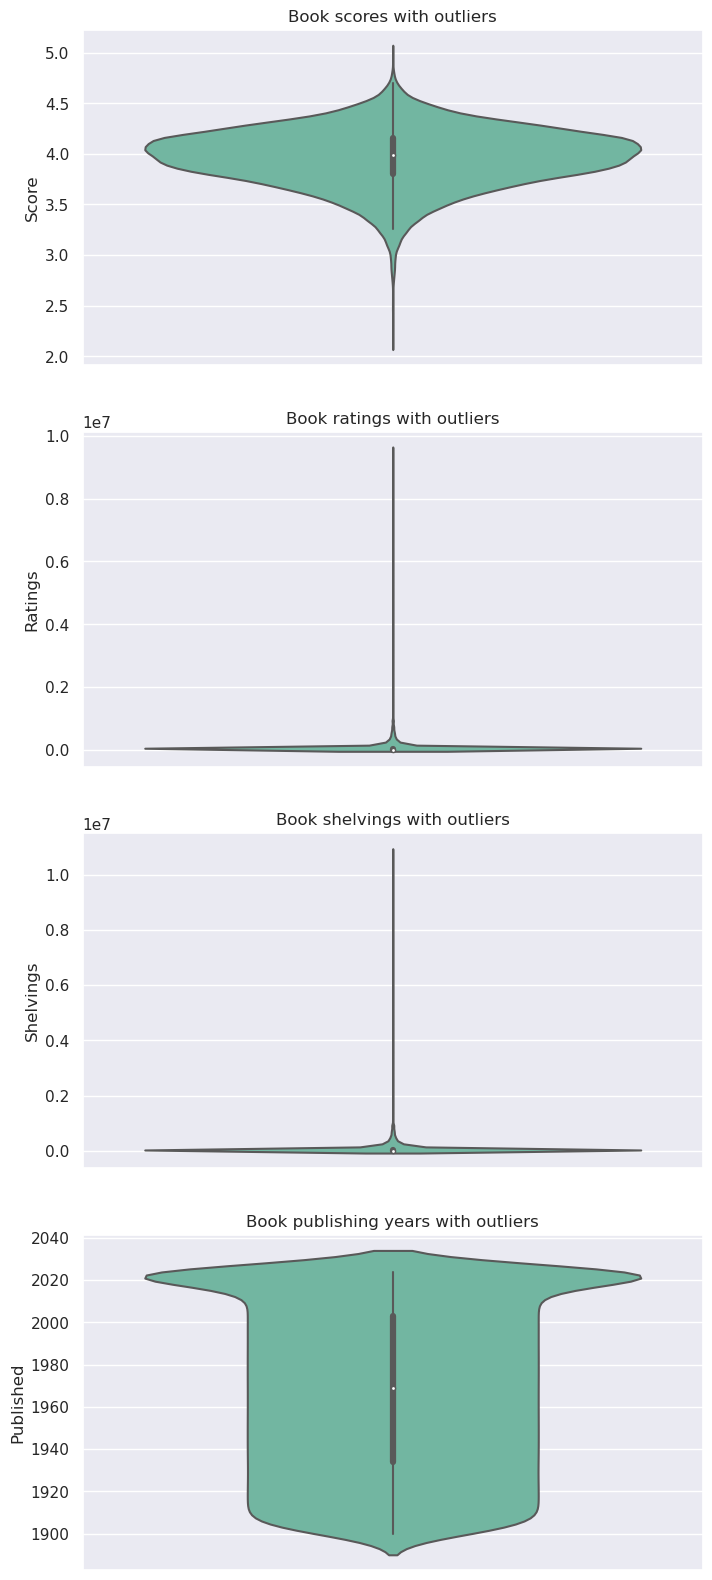

In [13]:
fig, axes = plt.subplots(4,1,figsize=(8,20))

sns.violinplot(data=books_df, y='Score', ax=axes[0])
axes[0].set_title("Book scores with outliers")

sns.violinplot(data=books_df, y='Ratings', ax=axes[1])
axes[1].set_title("Book ratings with outliers")

sns.violinplot(data=books_df, y='Shelvings', ax=axes[2])
axes[2].set_title("Book shelvings with outliers")

sns.violinplot(data=books_df, y='Published', ax=axes[3])
axes[3].set_title("Book publishing years with outliers")

plt.show()

The Ratings and Shelvings column have a largely skewed distribution due to a large number of outliers. Most of the Book Ratings are between 0-1000 as these contain ratings for trending and newer books that have been recently released. This trend is evident due to the distribution of the Published column which contain books ranging from 1900 to the current year. The number of books released recently are on average greater than other books as depicted by the T-shape of the violin plot above

In [14]:
books_df['Published'].value_counts()[:10]

2023    2266
2024     768
1930     200
1901     200
1999     200
1929     200
2014     200
1921     200
1990     200
1958     200
Name: Published, dtype: int64

The data has more books from the recent years compared to the past years. I will be treating the books published in or after 2020 (the new decade) to be the new ones and before 2020 to be the old ones.

In [15]:
new_books = books_df[books_df['Published'] >= 2020]
old_books = books_df[books_df.Published.isin(new_books.Published) == False]

print(f"{len(new_books)} books are published in 2020 and beyond")
print(f"{len(old_books)} books are published before 2020")

3634 books are published in 2020 and beyond
23987 books are published before 2020


# Answering interesting questions

### Q. Which are the top 10 most popular standalone books?

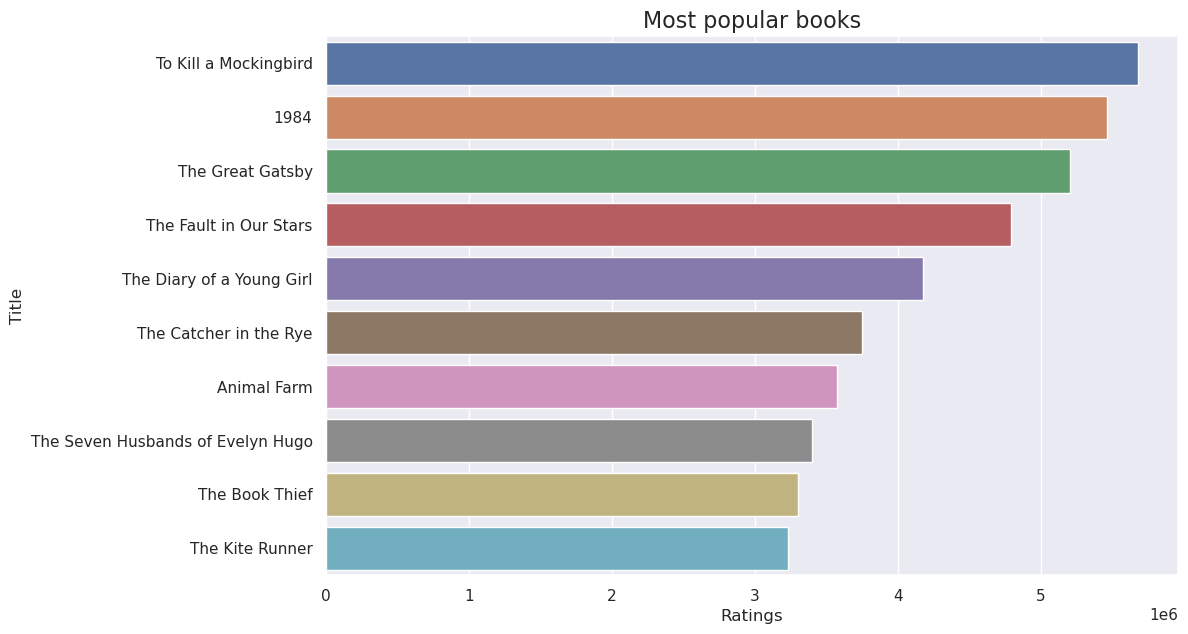

In [16]:
# Considering only standalone books
plt.figure(figsize=(11,7))
popular_df = books_df[books_df.Series == 'Standalone'].sort_values('Ratings', ascending=False)[:10]
sns.barplot(data=popular_df, x='Ratings', y='Title', palette='deep')
plt.title("Most popular books", fontsize=16)
plt.show()

**To Kill a MockingBird**, **1984** and **The Great Gatsby** are the 3 most popular books.

### Q. Who are the most popular authors?

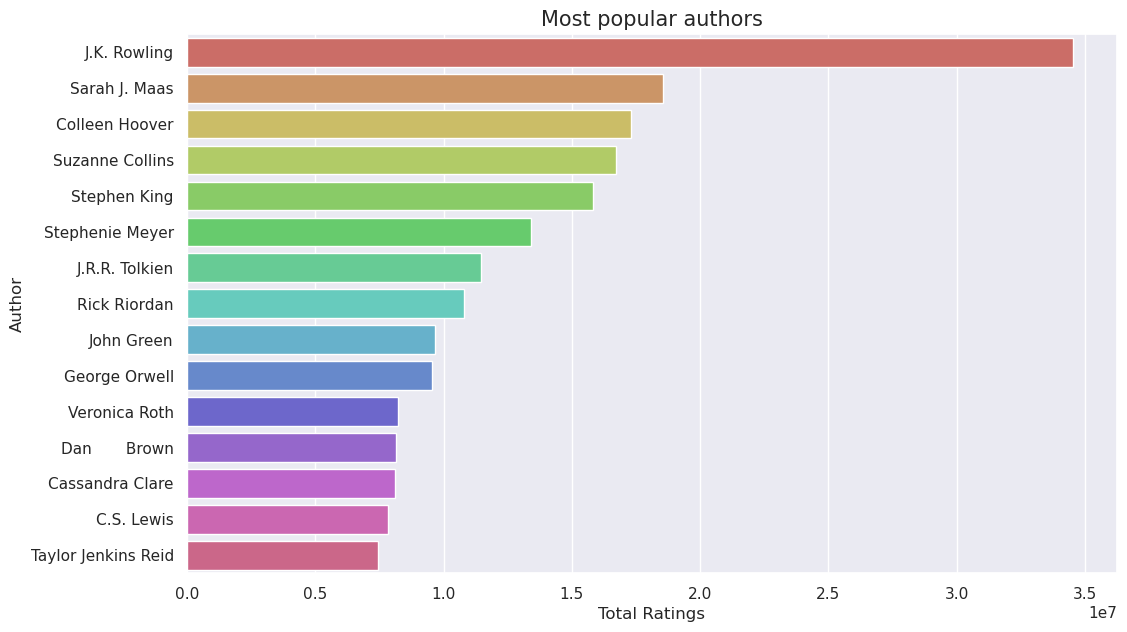

In [17]:
plt.figure(figsize=(12,7))
author_df = books_df.groupby('Author')['Ratings'].sum().sort_values(ascending=False)[:15].reset_index()
sns.barplot(data=author_df, x='Ratings', y='Author', palette='hls')
plt.xlabel("Total Ratings")
plt.title("Most popular authors", fontsize=15)
plt.show()

**J.K. Rowling** is the most popular author leading others by a large margin. **Sarah J. Maas** and **Colleen Hoover** follow with 2nd and 3rd place respectively.

### Q. What are the top 10 most popular book series?

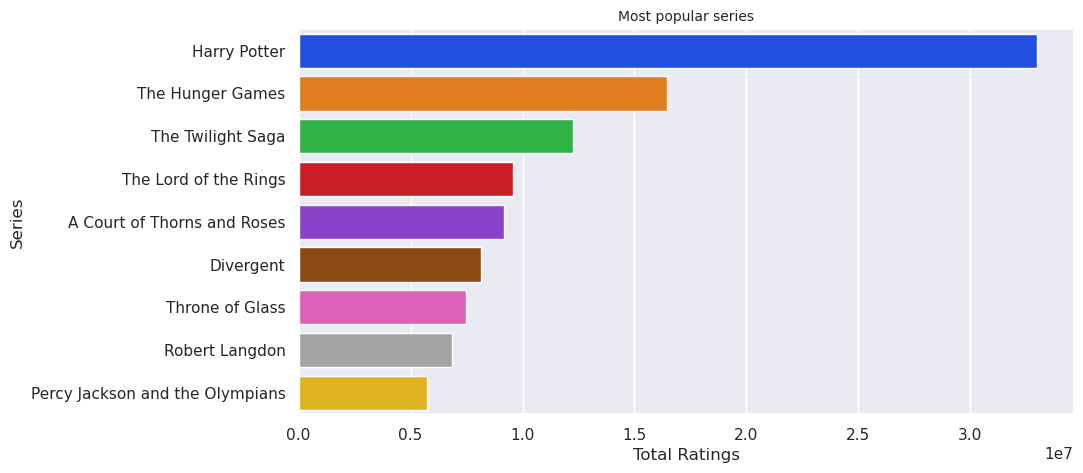

In [18]:
plt.figure(figsize=(10,5))
series_df = books_df.groupby('Series')['Ratings'].sum().sort_values(ascending=False)[1:10].reset_index()
sns.barplot(data=series_df, x='Ratings', y='Series', palette='bright')
plt.xlabel("Total Ratings")
plt.title("Most popular series", fontsize=10)
plt.show()

As usual the most popular book series are **Harry Potter, Hunger Games, Twilight Saga, and Lord of the Rings.**

### Q. Which authors have written the most books from our dataset?

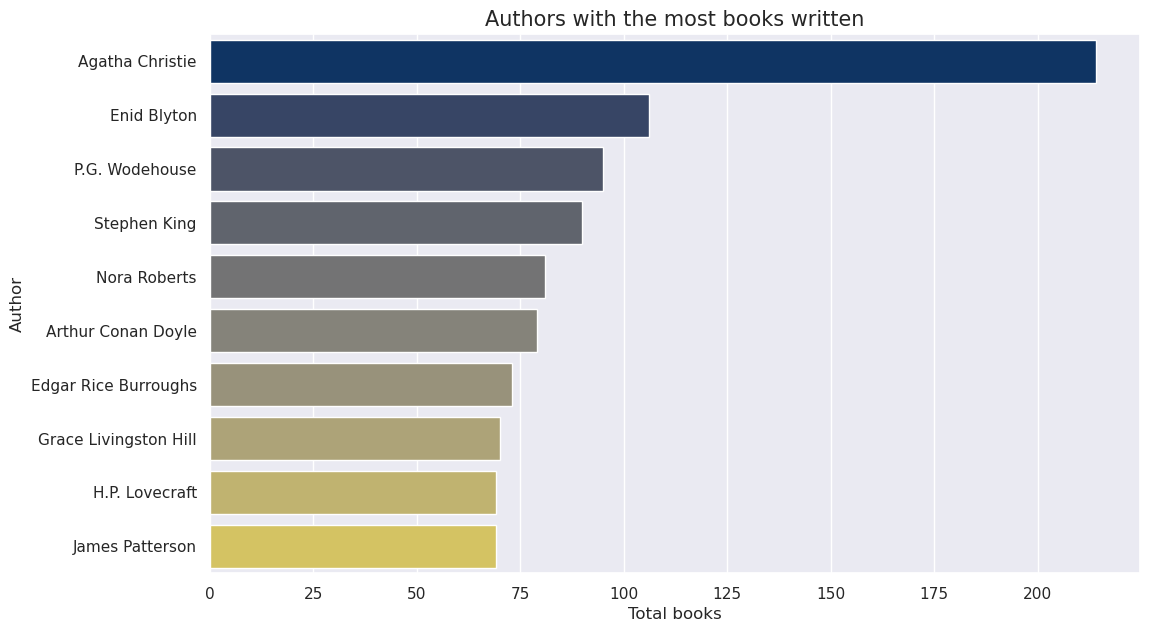

In [19]:
plt.figure(figsize=(12,7))
most_books = books_df.groupby('Author')['Title'].count().sort_values(ascending=False)[:10].reset_index()
sns.barplot(data=most_books, x='Title', y='Author', palette='cividis')
plt.xlabel("Total books")
plt.title("Authors with the most books written", fontsize=15)
plt.show()

**Agatha Christie** has the most books(~250) written among all authors. I like Mysterious Stuff!!🔮

### Q. Which are the best books according to the readers?

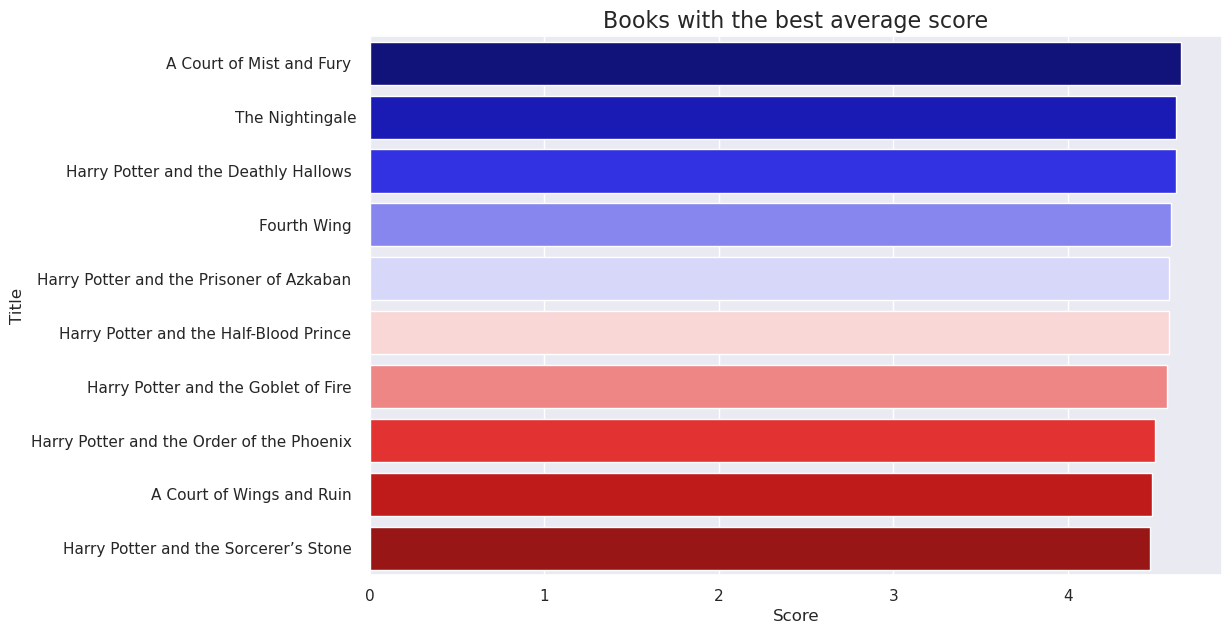

In [20]:
# Considering books with a score of 4.5 and above and ratings greater than 1,000,000
plt.figure(figsize=(11,7))
best_df = books_df[books_df.Ratings > 1_000_000].sort_values('Score', ascending=False)[:10]
sns.barplot(data=best_df, x='Score', y='Title', palette='seismic')
plt.title("Books with the best average score", fontsize=16)
plt.show()

WOW!! According to the users the **Harry Potter Series** is also the best quality series ever written.

## Book Description Analysis

Descriptive Statistics
Word Count: Calculate the number of words in each description.
Unique Words: Count the number of unique words per description.
Sentence Count: Determine the number of sentences.
Visualization
Word Clouds: Visualize the most common words.
TSNE/UMAP: Reduce dimensionality for visualizing text embeddings.
Comparative Analysis
Compare descriptions of bestsellers vs. non-bestsellers.
Compare descriptions across different genres or publication years.

In [40]:
books_df = books_df.dropna(subset=['Description']).copy()
books_df['word_count'] = books_df['Description'].apply(lambda x: len(x.strip().split()))
books_df.head()

,Title,Author,Score,Ratings,Shelvings,Published,Description,Series,word_count
0,The English Assassin,Daniel Silva,4.16,40122,44602,2002,"The Unlikely Spy, Daniel Silva's extraordinary...",Gabriel Allon,143
1,Pompeii,Robert Harris,3.86,46097,64840,2003,With his trademark elegance and intelligence R...,Standalone,244
2,Notorious RBG: The Life and Times of Ruth Bade...,Irin Carmon,4.19,59670,171959,2015,You can't spell truth without Ruth.Only Ruth B...,Standalone,119
3,The Abolition of Man,C.S. Lewis,4.11,34390,52770,1943,Alternative cover for ISBN: 978-0060652944The ...,Standalone,44
4,Portrait of a Murderer,Anne Meredith (Pseudonym),3.38,1129,1739,1933,'Adrian Gray was born in May 1862 and met his ...,Standalone,118


In [44]:
books_df['word_count'].describe()

count    27549.000000
mean       136.573560
std         85.710662
min          1.000000
25%         75.000000
50%        125.000000
75%        183.000000
max       2818.000000
Name: word_count, dtype: float64

A book description roughly has 136 words on average. We can see that some books have as low as 1 word in their description text. We can remove these books from our dataset as this may not convey useful information.

In [76]:
# Getting rid of books with no or useless descriptions (variable is chosen based on analysis)
books_df = books_df[books_df['word_count'] < 10].copy()

## Word Clouds

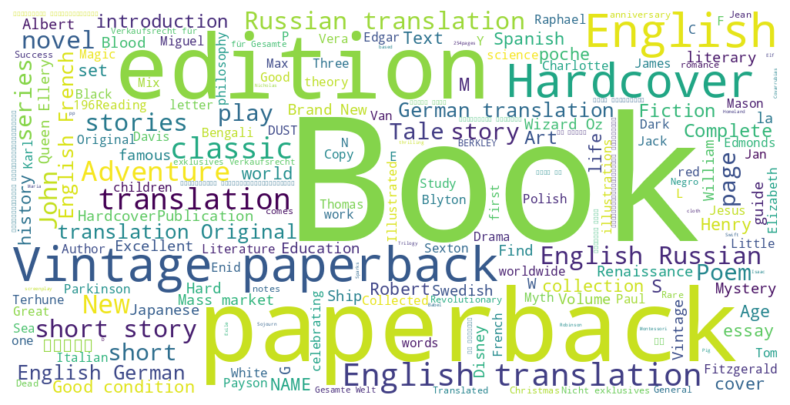

In [77]:
# Combine all descriptions into one text
text = " ".join(description for description in books_df['Description'])

# Remove stopwords
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in text.split() if word.lower() not in stop_words]
filtered_text = " ".join(filtered_words)

# Generate word cloud
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(filtered_text)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# mask_image = np.array(Image.open('path_to_book_shape_image.png'))

# Recommendation System

This notebook is currently under progress. I am working on more fun stuff and will be coming out with a new version of the notebook in a couple days. Stay tuned until then. 

If you liked the notebook or found it helpful you can consider giving it an upvote👍. It would be much appreciated. For more interesting stuff you can check out my other notebooks and datasets. 